In [1]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import math
from docplex.mp.model import Model

def showSolution(data,solution):
    
    # print the booking strategy
    print("Bookings:")
    for booking in solution['Bookings']:
        print(booking)

    # show the passes
    minVisiDuration = data['minVisiDuration']
    AOIs = data['AOIs']
    nAOIs = len(AOIs)
    accesses = data['Accesses']
    satPasses = data['Passes']
    nPasses = len(satPasses)
    
    ncols = 3
    nrows = math.ceil(nPasses / ncols)
    proj = ccrs.PlateCarree()
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols, subplot_kw={'projection': proj},figsize=(30,80))
    axs = axs.flatten()

    for i in range(nPasses):
        satPass = satPasses[i]
        ax = axs[i]
        ax.set_extent([-15, 25, 35, 60])
        ax.stock_img()
        ax.add_feature(cf.COASTLINE, lw=1)
        ax.add_feature(cf.BORDERS)
        #plt.gcf().set_size_inches(15, 15)    
        for aoi in  AOIs:
            ax.plot([aoi['lon']], [aoi['lat']], 'kx')
        ax.set_title("Pass #{} [{},{}]".format(i,satPass['startDate'],satPass['endDate']))
    
        booking = None
        for bk in solution['Bookings']:
            if bk['passId'] == i:
                booking = bk            
                break
        
        for accessId in satPass['accessIds']:
            access = accesses[accessId]
            aoi = AOIs[access['aoiId']]            
            ax.plot([aoi['lon']], [aoi['lat']], 'rx')
            # show the reservations
            if (booking != None) and (booking['bookingStart'] <= access['end'] - minVisiDuration) and (access['start'] + minVisiDuration <= booking['bookingEnd']):
                ax.plot([aoi['lon']], [aoi['lat']], 'bo')

    plt.show()

In [5]:
import random
import json

# import the data

dataFile = open('data/data12.json')  
data = json.load(dataFile)
accesses = data['Accesses']
obsRequests = data['ObservationRequests'];
nObsRequests = len(obsRequests)
covered = [False for i in range(nObsRequests)]
nObsRequestsToCover = nObsRequests
satPasses = data['Passes'];
nPasses = len(satPasses)

# a very basic solver

remainingSatPassesIds = list(range(nPasses))
random.shuffle(remainingSatPassesIds)
selectedPassIds = []
for i in remainingSatPassesIds:
    # try to select the ith path
    satPass = satPasses[i]
    keepPass = False
    for accessId in satPass['accessIds']:
        access = accesses[accessId]
        for j in range(nObsRequests):
            obsRequest = obsRequests[j]
            if not covered[j] and accessId in obsRequest['accessIds']:
                covered[j] = True
                keepPass = True
                nObsRequestsToCover -= 1
                
    if keepPass:
        selectedPassIds.append(i)
            
    if nObsRequestsToCover == 0:
        break

print(selectedPassIds)
print(len(selectedPassIds))

# OBJECTIVE MISSION to be optimized
time_cost = sum([satPasses[id]['end'] - satPasses[id]['start'] for id in selectedPassIds])
print(len(selectedPassIds)*data['fixedPassCost'] + time_cost*data['passCostPerTimeUnit'])

# export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": satPass['start'], "bookingEnd": satPass['end']})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolution.json", "w")
jsonFile.write(jsonString)
jsonFile.close()


[1, 23, 58, 6, 32, 60, 9, 2, 34]
9
3520


Bookings:
{'passId': 5, 'passStart': 3295, 'passEnd': 3437, 'bookingStart': 3295, 'bookingEnd': 3437}
{'passId': 45, 'passStart': 30130, 'passEnd': 30184, 'bookingStart': 30130, 'bookingEnd': 30184}
{'passId': 25, 'passStart': 16809, 'passEnd': 17113, 'bookingStart': 16809, 'bookingEnd': 17113}
{'passId': 65, 'passStart': 41141, 'passEnd': 41216, 'bookingStart': 41141, 'bookingEnd': 41216}
{'passId': 34, 'passStart': 23170, 'passEnd': 23507, 'bookingStart': 23170, 'bookingEnd': 23507}
{'passId': 32, 'passStart': 21960, 'passEnd': 22144, 'bookingStart': 21960, 'bookingEnd': 22144}
{'passId': 12, 'passStart': 8318, 'passEnd': 8612, 'bookingStart': 8318, 'bookingEnd': 8612}
{'passId': 56, 'passStart': 35877, 'passEnd': 36205, 'bookingStart': 35877, 'bookingEnd': 36205}
{'passId': 26, 'passStart': 17649, 'passEnd': 17994, 'bookingStart': 17649, 'bookingEnd': 17994}
{'passId': 33, 'passStart': 22326, 'passEnd': 22618, 'bookingStart': 22326, 'bookingEnd': 22618}
{'passId': 61, 'passStart': 3

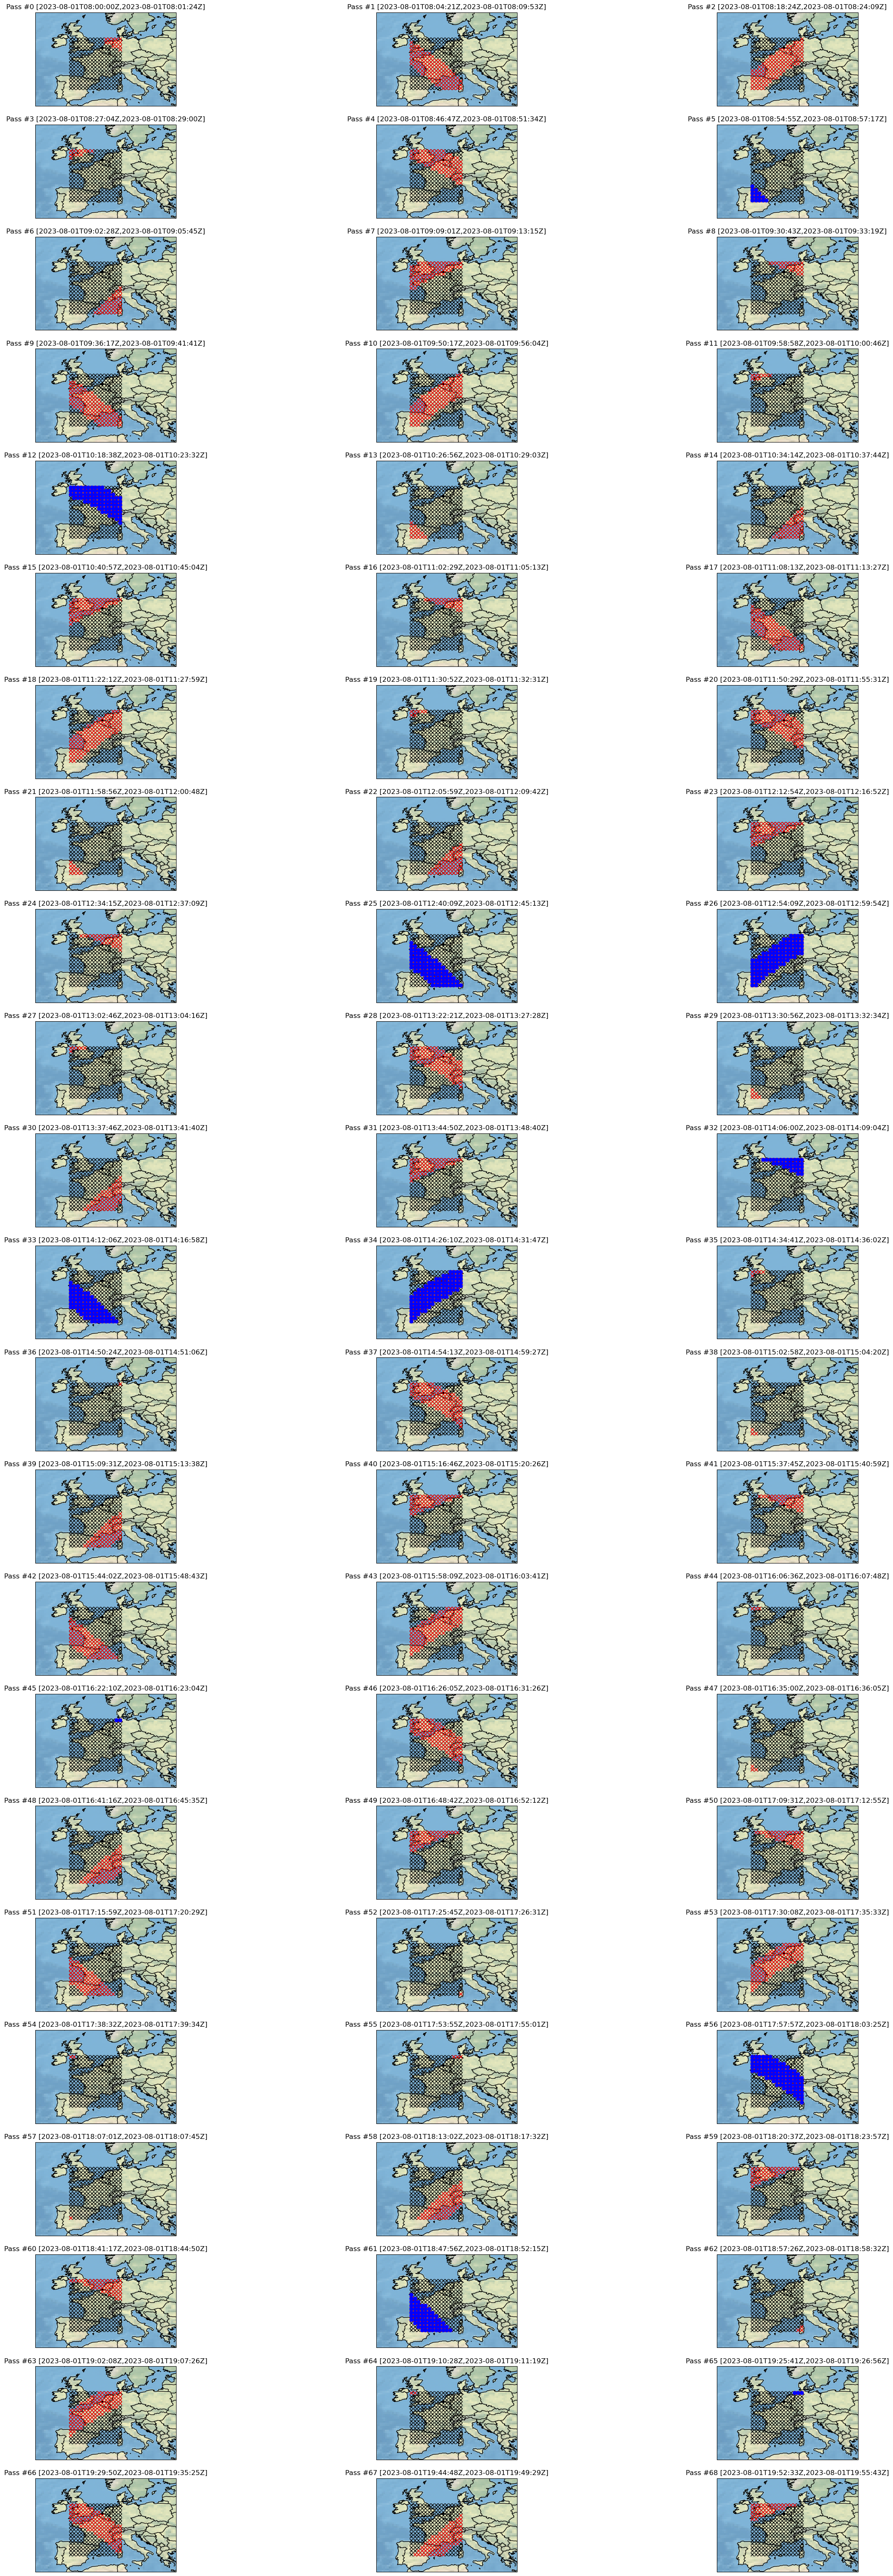

In [3]:
# import the solution
solutionFile = open('mySolution.json')  
solution = json.load(solutionFile)

showSolution(data,solution)